In [2]:
!pip install sqlalchemy
!pip install pyodbc

In [3]:
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd

In [4]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [5]:
engine = new_engine('mssql', 'SE310197', 'AdventureWorks2022', integrated_security=True)

mssql://SE310197/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [6]:
print(type(engine))

<class 'sqlalchemy.engine.base.Engine'>


In [7]:
connection = engine.connect()

In [8]:
print(type(connection))

<class 'sqlalchemy.engine.base.Connection'>


In [9]:
inspector = inspect(engine)
schemas = inspector.get_schema_names()
print(schemas)

['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys']


In [10]:
import matplotlib.pyplot as plt

In [98]:
#Skapa en dataframe från query i sql kring totala försäjningssumman per kontinent. Eftersom det är stora siffror dividerar jag 
#summorna med en miljon, för att få siffrorna i miljon dollar. Jag har antagit, efter lite googlande och utforskande av 
#tabellerna, att samtliga summor och belopp är i USD. Jag har valt att fokusera på innevarande år (vilket är 2014-01-01 -2014-06-30)
#och föregående år (2013)

query_sql ="""
SELECT
  st.[Group] AS 'Territory', 
  SUM (st.SalesYTD) / 1000000 AS 'SalesYTD', 
  SUM (st.SalesLastYear) /1000000 AS 'SalesLastYear'
FROM Sales.SalesTerritory AS st
GROUP BY st.[Group]

"""
df = pd.read_sql(sql=query_sql, con=connection)


In [99]:
df.head()

,Territory,SalesYTD,SalesLastYear
0,Europe,13.5905,5.3403
1,North America,33.1828,25.0964
2,Pacific,5.9778,2.2785


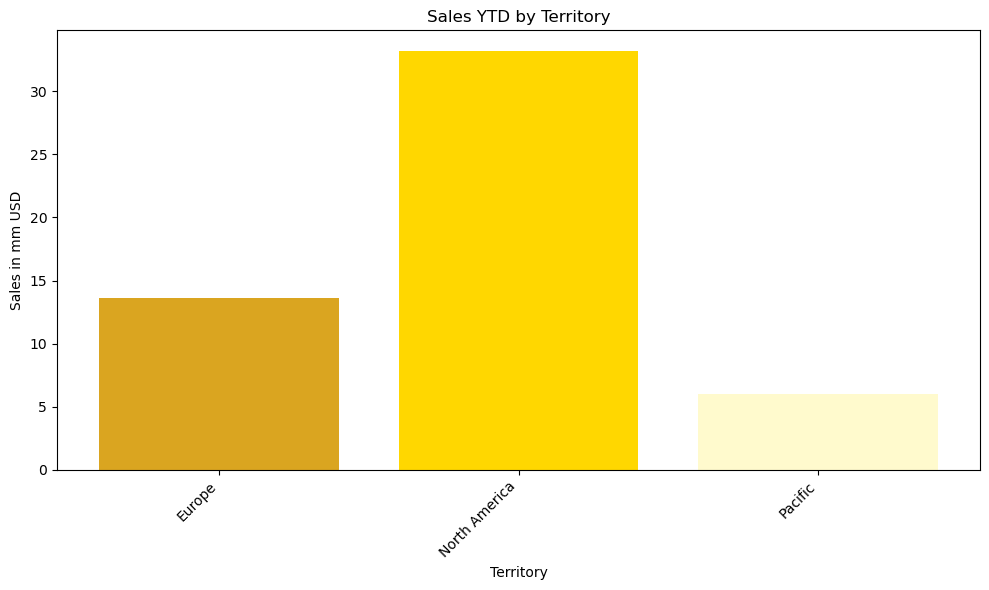

In [16]:
#stapeldiagram över försäljningssifforna. 

territory = df['Territory']
sales_ytd = df['SalesYTD']
sales_lastyear = df['SalesLastYear']

color = ['goldenrod', 'gold', 'lemonchiffon']

plt.figure(figsize=(10, 6))  
plt.bar(territory, sales_ytd, color = color)
plt.xlabel('Territory')
plt.ylabel('Sales in mm USD')
plt.title('Sales YTD by Territory')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

C:\Users\niksan2\AppData\Local\Temp\ipykernel_20392\3112736692.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(territory, rotation=45, ha='right')
C:\Users\niksan2\AppData\Local\Temp\ipykernel_20392\3112736692.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(territory, rotation=45, ha='right')


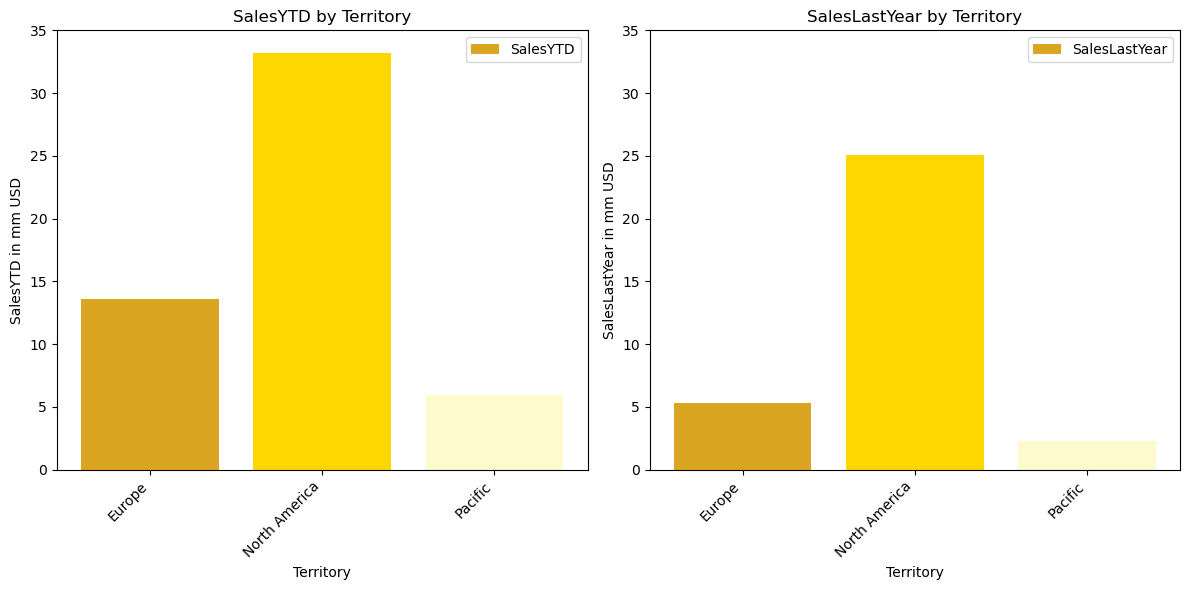

In [102]:
territory = df['Territory']
sales_ytd = df['SalesYTD']
sales_lastyear = df['SalesLastYear']

color = ['goldenrod', 'gold', 'lemonchiffon']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axs[0].bar(territory, sales_ytd, color= color, label='SalesYTD')
axs[0].set_xlabel('Territory')
axs[0].set_ylabel('SalesYTD in mm USD')
axs[0].set_title('SalesYTD by Territory')
axs[0].set_xticklabels(territory, rotation=45, ha='right')
axs[0].set_ylim([0, 35])
axs[0].legend()

# Subplot 2: SalesLastYear
axs[1].bar(territory, sales_lastyear, color= color, label='SalesLastYear')
axs[1].set_xlabel('Territory')
axs[1].set_ylabel('SalesLastYear in mm USD')
axs[1].set_title('SalesLastYear by Territory')
axs[1].set_xticklabels(territory, rotation=45, ha='right')
axs[1].set_ylim([0, 35])
axs[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
multijoin_sql ="""
SELECT
  pc.[Name] AS 'ProductCategory', 
  SUM (sod.LineTotal) / 1000000 AS 'TotalSales' 
FROM Sales.SalesOrderDetail AS sod INNER JOIN Production.Product AS p 
    ON sod.ProductID = p.ProductID
INNER JOIN Sales.SalesOrderHeader as soh
    ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.ProductSubcategory AS psc
    ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory AS pc
    ON psc.ProductCategoryID = pc.ProductCategoryID
WHERE soh.OrderDate >= '2014-01-01'
GROUP BY pc.[Name]

"""
multijoin_df = pd.read_sql(sql=multijoin_sql, con=connection)

In [19]:
multijoin_df.head()

,ProductCategory,TotalSales
0,Clothing,0.461233
1,Bikes,17.453180
2,Accessories,0.473787
3,Components,1.669726


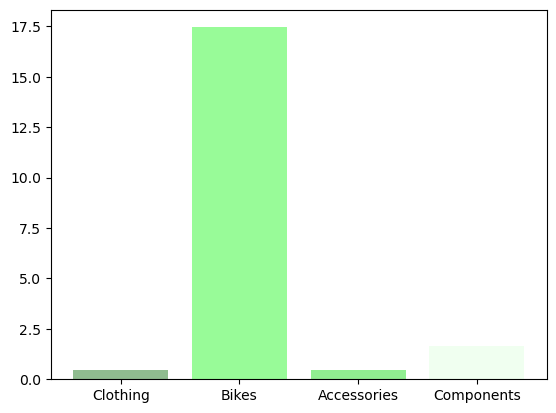

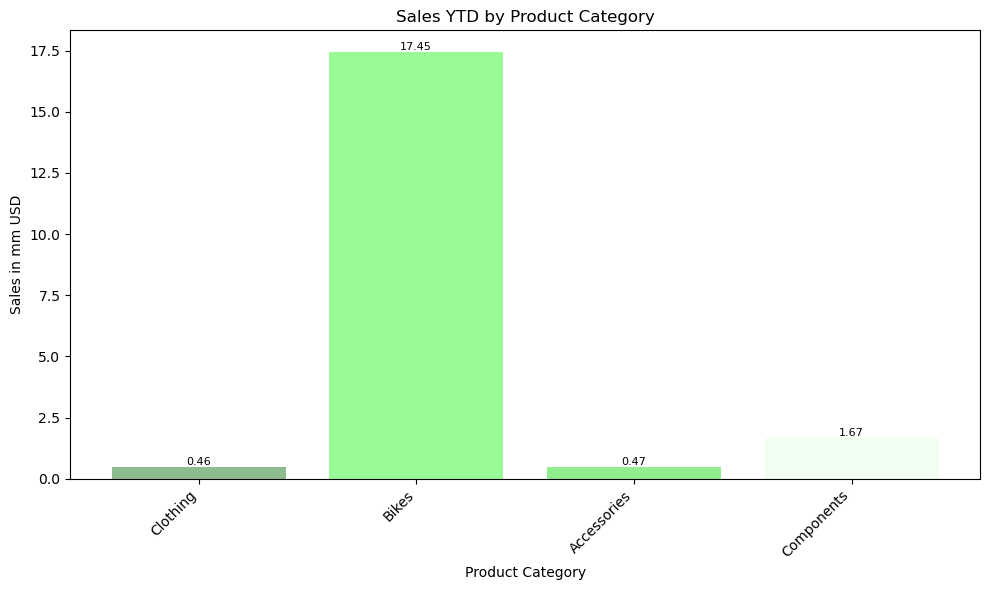

In [20]:
product_category = multijoin_df['ProductCategory']
sales_ytd = multijoin_df['TotalSales']

color = ['darkseagreen', 'palegreen', 'lightgreen', 'honeydew']
barz = plt.bar(product_category, sales_ytd, color=color)

plt.figure(figsize=(10, 6))  
plt.bar(product_category, sales_ytd, color = color)
plt.xlabel('Product Category')
plt.ylabel('Sales in mm USD')
plt.title('Sales YTD by Product Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for bar, value in zip(barz, sales_ytd):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', 
             ha='center', va='bottom', fontsize=8, color='black')


plt.show()

In [21]:
multijoin2_sql ="""
SELECT
  pc.[Name] AS 'ProductCategory', 
  SUM (sod.LineTotal) / 1000000 AS 'TotalSales' 
FROM Sales.SalesOrderDetail AS sod INNER JOIN Production.Product AS p 
    ON sod.ProductID = p.ProductID
INNER JOIN Sales.SalesOrderHeader as soh
    ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.ProductSubcategory AS psc
    ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory AS pc
    ON psc.ProductCategoryID = pc.ProductCategoryID
WHERE soh.OrderDate >= '2013-01-01' AND soh.OrderDate <= '2013-12-31'
GROUP BY pc.[Name]

"""
multijoin2_df = pd.read_sql(sql=multijoin2_sql, con=connection)

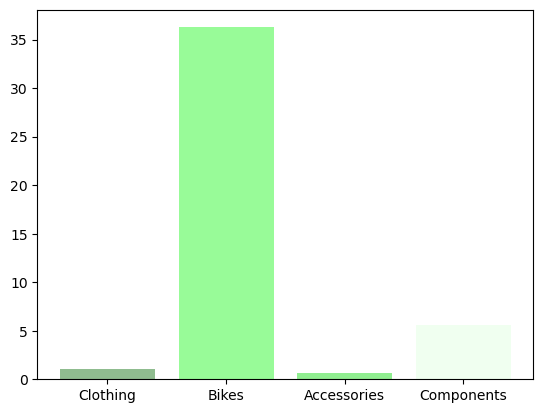

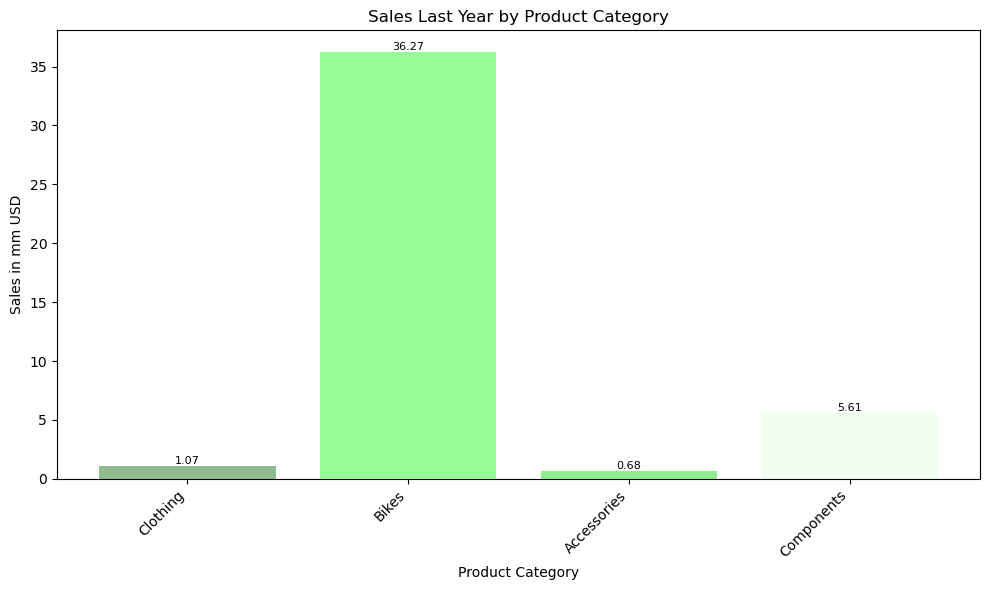

In [22]:
product_category = multijoin2_df['ProductCategory']
sales_2013 = multijoin2_df['TotalSales']

color = ['darkseagreen', 'palegreen', 'lightgreen', 'honeydew']
bars = plt.bar(product_category, sales_2013, color=color)


plt.figure(figsize=(10, 6))  
plt.bar(product_category, sales_2013, color=color)
plt.xlabel('Product Category')
plt.ylabel('Sales in mm USD')
plt.title('Sales Last Year by Product Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for bar, value in zip(bars, sales_2013):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', 
             ha='center', va='bottom', fontsize=8, color='black')

plt.show()

In [74]:
multijoin3_sql ="""
SELECT
  psc.[Name] AS 'ProductSubCategory', 
  SUM (sod.LineTotal) / 1000000 AS 'TotalSales' 
FROM Sales.SalesOrderDetail AS sod INNER JOIN Production.Product AS p 
    ON sod.ProductID = p.ProductID
INNER JOIN Sales.SalesOrderHeader as soh
    ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.ProductSubcategory AS psc
    ON p.ProductSubcategoryID = psc.ProductSubcategoryID
WHERE psc.ProductSubcategoryID >= 1 AND psc.ProductSubcategoryID <= 3 AND soh.OrderDate >= '2014-01-01'
GROUP BY psc.[Name]

"""

multijoin3_df = pd.read_sql(sql=multijoin3_sql, con=connection)

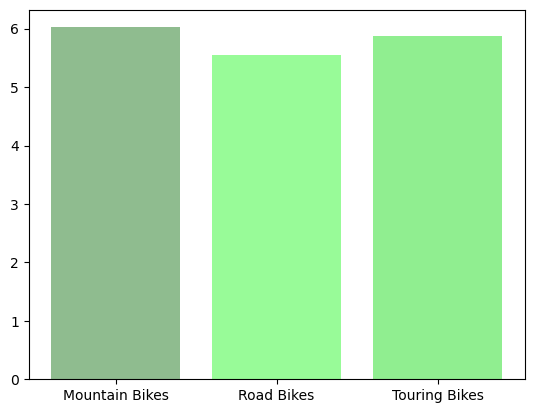

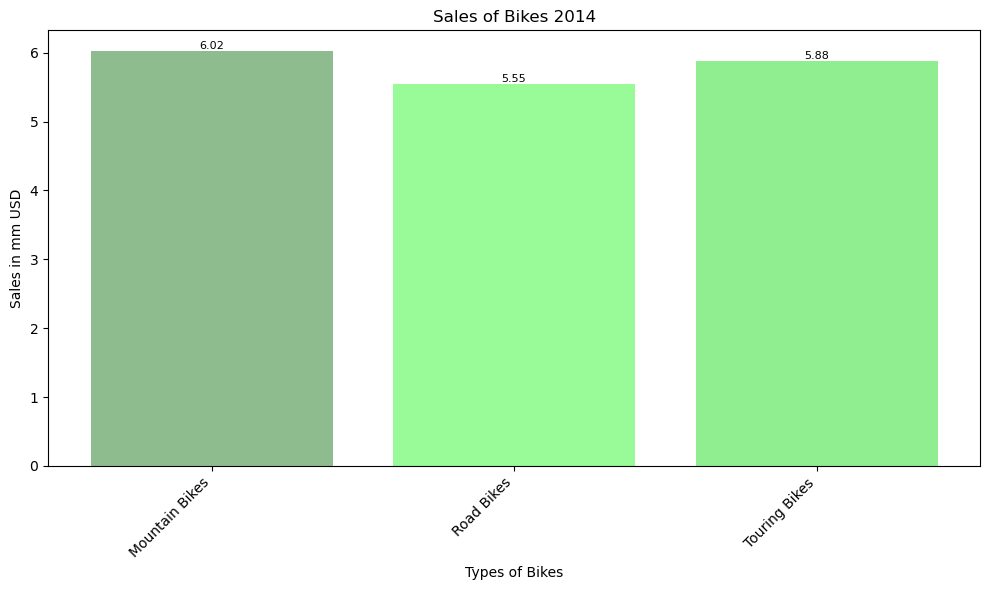

In [76]:
product_subcategory = multijoin3_df['ProductSubCategory']
sales_lt = multijoin3_df['TotalSales']

color = ['darkseagreen', 'palegreen', 'lightgreen', 'honeydew']
bars = plt.bar(product_subcategory, sales_lt, color=color)


plt.figure(figsize=(10, 6))  
plt.bar(product_subcategory, sales_lt, color=color)
plt.xlabel('Types of Bikes')
plt.ylabel('Sales in mm USD')
plt.title('Sales of Bikes 2014')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for bar, value in zip(bars, sales_lt):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', 
             ha='center', va='bottom', fontsize=8, color='black')

plt.show()

In [94]:
querybikes_sql = """
SELECT COUNT (sod.OrderQTY) AS 'Sold Touring Bikes'
  , sr.ReasonType AS 'ReasonType'
  FROM Sales.SalesOrderDetail AS sod INNER JOIN Sales.SalesOrderHeaderSalesReason AS sohr
    ON sod.SalesOrderID = sohr.SalesOrderID
INNER JOIN Sales.SalesReason AS sr
    ON sohr.SalesReasonID = sr.SalesReasonID
INNER JOIN Sales.SalesOrderHeader AS soh
    ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.Product AS p
    ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductModel AS pm
    ON p.ProductModelID = pm.ProductModelID
WHERE pm.ProductModelID >= 34 AND pm.ProductModelID <= 36 
GROUP BY sr.ReasonType;

"""

querybikes_df = pd.read_sql(sql=querybikes_sql, con=connection)
querybikes_df.head()

,Sold Touring Bikes,ReasonType
0,1453,Other
1,571,Promotion


In [97]:
querybikes1_sql = """
SELECT COUNT (sod.OrderQTY) AS 'Sold Touring Bikes'
  , sr.[Name] AS 'ReasonName'
  FROM Sales.SalesOrderDetail AS sod INNER JOIN Sales.SalesOrderHeaderSalesReason AS sohr
    ON sod.SalesOrderID = sohr.SalesOrderID
INNER JOIN Sales.SalesReason AS sr
    ON sohr.SalesReasonID = sr.SalesReasonID
INNER JOIN Sales.SalesOrderHeader AS soh
    ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.Product AS p
    ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductModel AS pm
    ON p.ProductModelID = pm.ProductModelID
WHERE pm.ProductModelID >= 34 AND pm.ProductModelID <= 36 
GROUP BY sr.[Name];


"""

querybikes1_df = pd.read_sql(sql=querybikes1_sql, con=connection)
querybikes1_df.head()

,Sold Touring Bikes,ReasonName
0,187,Manufacturer
1,571,On Promotion
2,22,Other
3,1244,Price


In [25]:
multijoin4_sql ="""
SELECT
  psc.[Name] AS 'ProductSubCategory', 
  SUM (sod.LineTotal) / 1000000 AS 'TotalSales' 
FROM Sales.SalesOrderDetail AS sod INNER JOIN Production.Product AS p 
    ON sod.ProductID = p.ProductID
INNER JOIN Sales.SalesOrderHeader as soh
    ON sod.SalesOrderID = soh.SalesOrderID
INNER JOIN Production.ProductSubcategory AS psc
    ON p.ProductSubcategoryID = psc.ProductSubcategoryID
WHERE psc.ProductSubcategoryID >= 1 AND psc.ProductSubcategoryID <= 3
GROUP BY psc.[Name]

"""

multijoin3_df = pd.read_sql(sql=multijoin3_sql, con=connection)

In [26]:
query2_sql = """
 SELECT 
 hr.Department AS 'Department'
    , COUNT (*) AS 'NumberOfEmployees'
FROM HumanResources.vEmployeeDepartment AS hr
GROUP BY Department

"""

query2_df = pd.read_sql(sql=query2_sql, con=connection)

In [27]:
query2_df.head(16)

,Department,NumberOfEmployees
0,Document Control,5
1,Engineering,6
2,Executive,2
3,Facilities and Maintenance,7
4,Finance,10
5,Human Resources,6
6,Information Services,10
7,Marketing,9
8,Production,179
9,Production Control,6


In [28]:
query3_sql = """
 SELECT 
 hr.Gender AS 'Gender'
    , COUNT (*) AS 'NumberOfEmployees'
FROM HumanResources.Employee AS hr
GROUP BY Gender

"""

query3_df = pd.read_sql(sql=query3_sql, con=connection)

In [29]:
query3_df.head()

,Gender,NumberOfEmployees
0,F,84
1,M,206


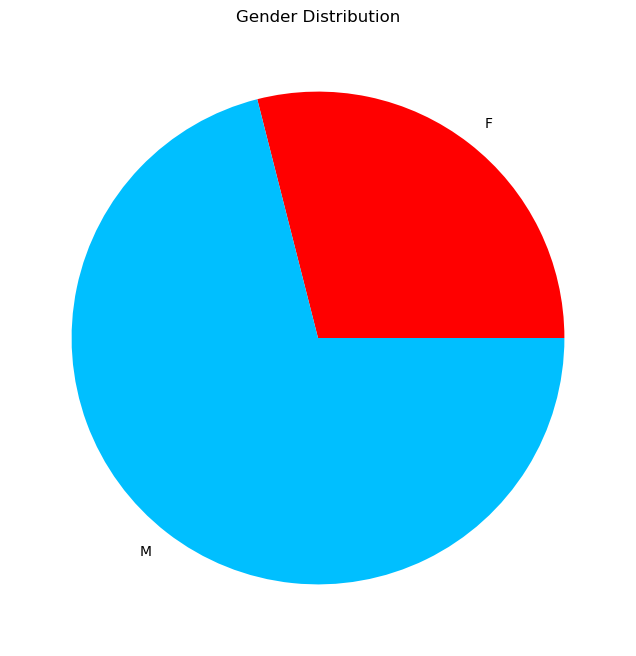

In [30]:
gender = query3_df['Gender']
number_empl = query3_df['NumberOfEmployees']

plt.figure(figsize=(8, 8))
plt.pie(number_empl, labels=gender, colors = ['red', 'deepskyblue'])
plt.title ('Gender Distribution')
plt.show()

In [31]:
query4_sql = """
 SELECT 
 hr.Gender AS 'Gender'
    , COUNT (*) AS 'NumberOfEmployees'
    , ved.Department AS 'Department'
FROM HumanResources.Employee AS hr
    FULL OUTER JOIN HumanResources.vEmployeeDepartment AS ved
        ON hr.BusinessEntityID = ved.BusinessEntityID
GROUP BY Gender, Department


"""

query4_df = pd.read_sql(sql=query4_sql, con=connection)

In [32]:
query4_df.head(32)

,Gender,NumberOfEmployees,Department
0,F,1,Document Control
1,M,4,Document Control
2,F,3,Engineering
3,M,3,Engineering
4,F,1,Executive
5,M,1,Executive
6,F,2,Facilities and Maintenance
7,M,5,Facilities and Maintenance
8,F,5,Finance
9,M,5,Finance


In [73]:
query5_sql = """
 SELECT 
 hr.Gender AS 'Women'
    , COUNT (*) AS 'NumberOfEmployees'
    , ved.Department AS 'Department'
FROM HumanResources.Employee AS hr
    LEFT JOIN HumanResources.vEmployeeDepartment AS ved
        ON hr.BusinessEntityID = ved.BusinessEntityID
WHERE hr.Gender = 'F'
GROUP BY Gender, Department


"""

query5_df = pd.read_sql(sql=query5_sql, con=connection)
query5_df.head(16)

,Women,NumberOfEmployees,Department
0,F,1,Document Control
1,F,3,Engineering
2,F,1,Executive
3,F,2,Facilities and Maintenance
4,F,5,Finance
5,F,2,Human Resources
6,F,4,Information Services
7,F,4,Marketing
8,F,46,Production
9,F,4,Purchasing


In [72]:
query6_sql = """
 SELECT 
 hr.Gender AS 'Men'
    , COUNT (*) AS 'NumberOfEmployees'
    , ved.Department AS 'Department'
FROM HumanResources.Employee AS hr
    LEFT JOIN HumanResources.vEmployeeDepartment AS ved
        ON hr.BusinessEntityID = ved.BusinessEntityID
WHERE hr.Gender = 'M'
GROUP BY Gender, Department


"""

query6_df = pd.read_sql(sql=query6_sql, con=connection)
query6_df.head(16)

,Men,NumberOfEmployees,Department
0,M,4,Document Control
1,M,3,Engineering
2,M,1,Executive
3,M,5,Facilities and Maintenance
4,M,5,Finance
5,M,4,Human Resources
6,M,6,Information Services
7,M,5,Marketing
8,M,133,Production
9,M,6,Production Control


In [35]:
import pandas as pd

C:\Users\niksan2\AppData\Local\Temp\ipykernel_20392\1506060217.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(department_1, rotation=45, ha='right')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\niksan2\AppData\Local\Temp\ipykernel_20392\1506060217.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(department_2, rotation=45, ha='right')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


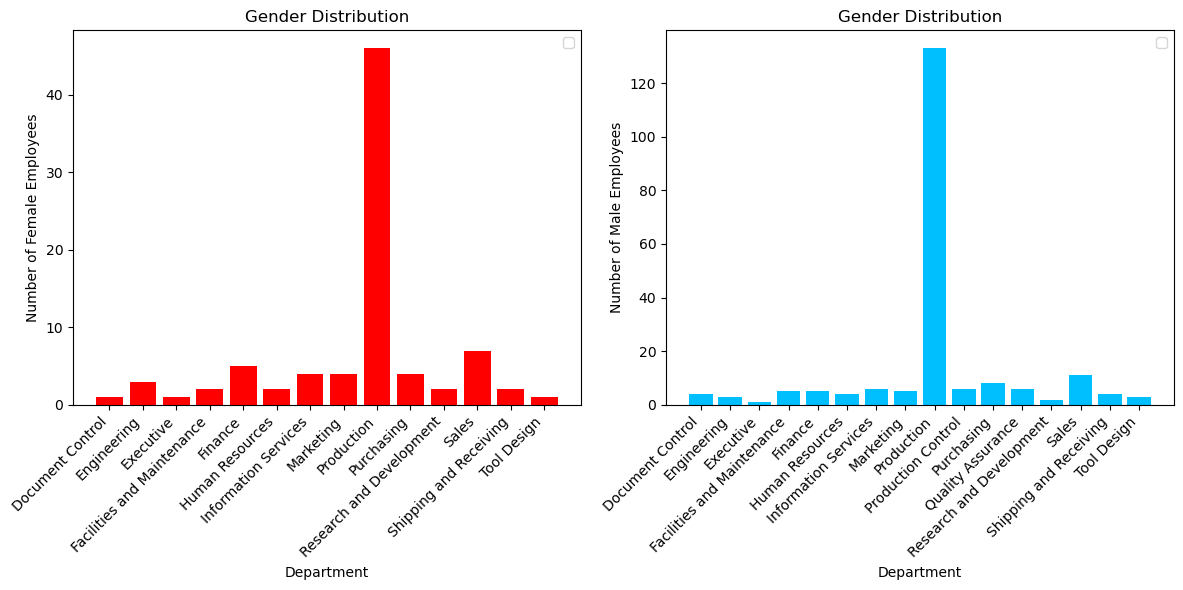

In [36]:
department_1 = query5_df['Department']
department_2 = query6_df['Department']
women = query5_df['NumberOfEmployees']
men = query6_df['NumberOfEmployees']

new_df = pd.concat([query5_df, query6_df], axis=1)


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axs[0].bar(department_1, women, color= 'red')
axs[0].set_xlabel('Department')
axs[0].set_ylabel('Number of Female Employees')
axs[0].set_title('Gender Distribution')
axs[0].set_xticklabels(department_1, rotation=45, ha='right')
axs[0].legend()

# Subplot 2: SalesLastYear
axs[1].bar(department_2, men, color= 'deepskyblue')
axs[1].set_xlabel('Department')
axs[1].set_ylabel('Number of Male Employees')
axs[1].set_title('Gender Distribution')
axs[1].set_xticklabels(department_2, rotation=45, ha='right')
axs[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
#Jag skapade två views, för manliga och kvinnliga anställda i de olika enheterna, för att lättare koppla samman dem till en 
#dataframe för att sedan kunna ta fram ett stapeldiagram som visar könsfördelningen av de anställda
viewquery_sql = """
 SELECT 
 vMaleWorkers.Male AS 'Men'
 , vFemaleWorkers.Female AS 'Women'
 , vMaleWorkers.Department AS 'Department'
 FROM dbo.vMaleWorkers
    LEFT JOIN dbo.vFemaleWorkers
ON vMaleWorkers.Department = vFemaleWorkers.Department
GROUP BY vMaleWorkers.Department, vMaleWorkers.Male,vFemaleWorkers.Female


"""

viewquery_df = pd.read_sql(sql=viewquery_sql, con=connection)
viewquery_df.head()

,Men,Women,Department
0,4,1.0,Document Control
1,3,3.0,Engineering
2,1,1.0,Executive
3,5,2.0,Facilities and Maintenance
4,5,5.0,Finance


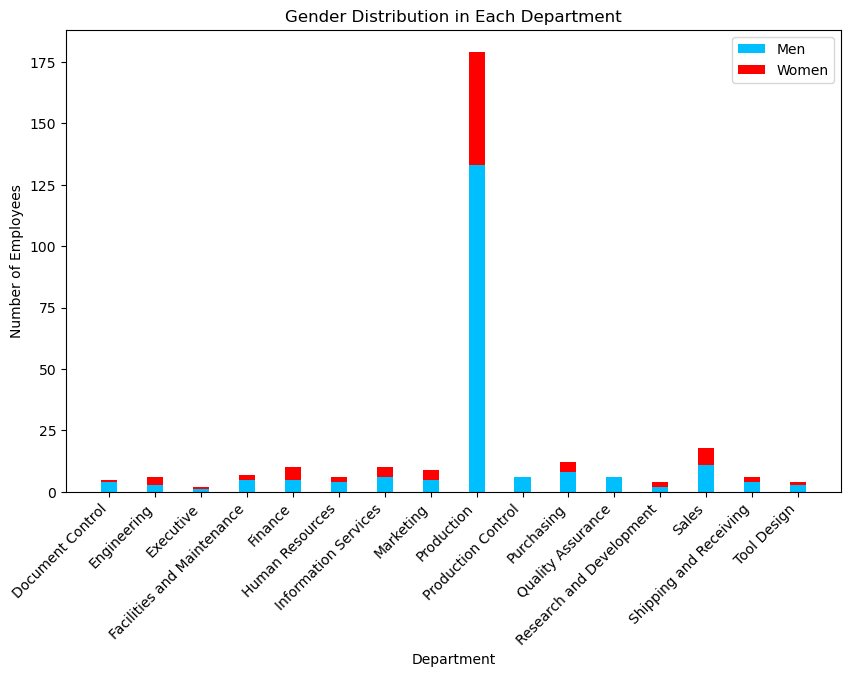

In [38]:
department = viewquery_df['Department']
women_1 = viewquery_df['Women']
men_1 = viewquery_df['Men']

color = ['red', 'deepskyblue']

bar_width = 0.35
index = range(len(department))

plt.figure(figsize=(10, 6))

plt.bar(index, men_1, width=bar_width, label='Men', color='deepskyblue')
plt.bar(index, women_1, width=bar_width, label='Women', color='red', bottom=men_1)

plt.xlabel('Department')
plt.ylabel('Number of Employees')
plt.title('Gender Distribution in Each Department')
plt.xticks(index, department)
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.show()

In [39]:
#Könsfördelning bland anställda med chefstitel
query7_sql = """
SELECT 
  Gender,
  Count(*)
FROM HumanResources.Employee
WHERE JobTitle LIKE '%Manager%'

GROUP BY Gender
"""

query7_df = pd.read_sql(sql=query7_sql, con=connection)


In [40]:
query7_df.head(10)

,Gender,
0,F,6
1,M,11


In [79]:
#Medelålder bland manliga anställda
query9_sql = """
SELECT AVG (DATEDIFF (year, '2023-12-27', BirthDate)) AS 'AverageAgeofMen'
FROM HumanResources.Employee 
WHERE Gender = 'M'
"""

query9_df = pd.read_sql(sql=query9_sql, con=connection)

query9_df.head()

,AverageAgeofMen
0,-44


In [80]:
#Medelålder bland kvinnliga anställda
query10_sql = """
SELECT AVG (DATEDIFF (year, '2023-12-27', BirthDate)) AS 'AverageAgeofWomen'
FROM HumanResources.Employee 
WHERE Gender = 'F'
"""

query10_df = pd.read_sql(sql=query10_sql, con=connection)

query10_df.head()

,AverageAgeofWomen
0,-45


In [81]:
query11_sql = """
SELECT AVG (DATEDIFF (year, '2023-12-26', BirthDate)) AS 'AvAgeFemaleManagers'
 FROM HumanResources.Employee
WHERE JobTitle LIKE '%Manager%' AND Gender = 'F'


"""

query11_df = pd.read_sql(sql=query11_sql, con=connection)

query11_df.head()


,AvAgeFemaleManagers
0,-47


In [82]:
query12_sql = """
SELECT AVG (DATEDIFF (year, '2023-12-26', BirthDate)) AS 'AvAgeMaleManagers'
 FROM HumanResources.Employee
WHERE JobTitle LIKE '%Manager%' AND Gender = 'M'


"""

query12_df = pd.read_sql(sql=query12_sql, con=connection)

query12_df.head()


,AvAgeMaleManagers
0,-47


In [45]:
import scipy.stats
import numpy as np

In [46]:
p = 6/17
n = 17
z = 1.96 #95% konfidensintervall
s_p = np.sqrt(p*(1-p)/n)

ci_lower = p - z*s_p
ci_upper = p + z*s_p

print(ci_lower)
print(ci_upper)

#Om könsfördelningen bland chefer är representativ för hela företaget är andelen kvinnor i hela företaget mellan 12,6 och 58 %

0.12576925204214065
0.5801131008990359


In [67]:
p1 = 6/17
p2 = 84/290
n = 17
s = np.sqrt((p1*(1-p1)/n) + (p2*(1-p2)/n))

x = scipy.stats.norm.rvs(loc = p1, scale = s, size = n )
print(scipy.stats.ttest_1samp(x, popmean=0.289, alternative = 'two-sided'))

#lågt p-värde --> vilket gör att vi förkastar nollhypotesen att andelen kvinnliga chefer är lika stor som andelen 
#totala kvinnliga anställda
#p-värdet påverkas dock av storleken på stickprovet, och då detta stickprov är väldigt litet 

TtestResult(statistic=-1.3818128969156631, pvalue=0.18601951398810365, df=16)
